## Overview

In this final notebook, we'll integrate everything we've learned by building a complete data analysis workflow. We'll:

1. Work with real-world data analysis libraries (NumPy, Pandas, Matplotlib)
2. Create custom modules for our analysis
3. Organize code into a logical package structure
4. Apply best practices for imports and documentation
5. Build a reproducible analysis pipeline

**Project**: Analyzing sales data to identify trends, seasonality, and anomalies

## Part 1: Using Data Analysis Libraries

### Standard Import Conventions

In [1]:
# Standard imports for data analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import random

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

print("Libraries imported successfully")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

Libraries imported successfully
NumPy version: 2.4.1
Pandas version: 3.0.0


### Generate Sample Sales Data

In [2]:
# Generate synthetic sales data for demonstration
def generate_sales_data(n_days=365):
    """
    Generate synthetic sales data with trends and seasonality.
    
    Parameters
    ----------
    n_days : int
        Number of days to generate
    
    Returns
    -------
    pd.DataFrame
        Sales data with date, product, quantity, and revenue
    """
    # Date range
    start_date = datetime(2024, 1, 1)
    dates = [start_date + timedelta(days=i) for i in range(n_days)]
    
    # Products
    products = ['Product_A', 'Product_B', 'Product_C', 'Product_D']
    base_prices = {'Product_A': 29.99, 'Product_B': 49.99, 
                   'Product_C': 19.99, 'Product_D': 39.99}
    
    data = []
    for date in dates:
        # Weekly seasonality (weekend boost)
        day_of_week = date.weekday()
        weekend_factor = 1.3 if day_of_week >= 5 else 1.0
        
        # Monthly trend (growing business)
        month_factor = 1 + (date.month / 12) * 0.2
        
        for product in products:
            # Base quantity with randomness
            base_qty = random.randint(10, 30)
            quantity = int(base_qty * weekend_factor * month_factor + np.random.normal(0, 3))
            quantity = max(0, quantity)  # No negative quantities
            
            # Revenue
            price = base_prices[product] * (1 + np.random.normal(0, 0.05))  # Price variation
            revenue = quantity * price
            
            data.append({
                'date': date,
                'product': product,
                'quantity': quantity,
                'price': price,
                'revenue': revenue
            })
    
    df = pd.DataFrame(data)
    
    # Add some missing values (realistic scenario)
    missing_indices = np.random.choice(df.index, size=int(len(df) * 0.02), replace=False)
    df.loc[missing_indices, 'quantity'] = np.nan
    
    # Add some outliers (data quality issues)
    outlier_indices = np.random.choice(df.index, size=5, replace=False)
    df.loc[outlier_indices, 'quantity'] *= 3
    
    return df

# Generate data
df = generate_sales_data(365)

print("Sales Data Generated")
print(f"Shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head())
print(f"\nData types:")
print(df.dtypes)
print(f"\nBasic statistics:")
print(df.describe())

Sales Data Generated
Shape: (1460, 5)

First few rows:
        date    product  quantity      price     revenue
0 2024-01-01  Product_A      31.0  29.782673  923.262853
1 2024-01-01  Product_B      15.0  53.796813  806.952197
2 2024-01-01  Product_C       9.0  19.755980  177.803821
3 2024-01-01  Product_D      23.0  41.524486  955.063172
4 2024-01-02  Product_A      15.0  30.803569  462.053532

Data types:
date        datetime64[us]
product                str
quantity           float64
price              float64
revenue            float64
dtype: object

Basic statistics:
                      date     quantity        price      revenue
count                 1460  1431.000000  1460.000000  1460.000000
mean   2024-07-01 00:00:00    23.960168    35.068405   836.317778
min    2024-01-01 00:00:00     5.000000    17.095193   117.372593
25%    2024-04-01 00:00:00    17.000000    25.548090   518.718416
50%    2024-07-01 00:00:00    23.000000    35.020316   761.174919
75%    2024-09-30 00:00:00

## Part 2: Creating Custom Analysis Modules

### Module 1: Data Quality Checks

In [3]:
# This would be in a separate file: data_quality.py

def check_missing_values(df):
    """
    Analyze missing values in DataFrame.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame to analyze
    
    Returns
    -------
    pd.DataFrame
        Summary of missing values by column
    """
    missing_count = df.isnull().sum()
    missing_percent = (missing_count / len(df)) * 100
    
    missing_df = pd.DataFrame({
        'missing_count': missing_count,
        'missing_percent': missing_percent
    })
    
    return missing_df[missing_df['missing_count'] > 0].sort_values('missing_count', ascending=False)

def detect_outliers_iqr(series):
    """
    Detect outliers using IQR method.
    
    Parameters
    ----------
    series : pd.Series
        Numerical data series
    
    Returns
    -------
    dict
        Dictionary with outlier information
    """
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = series[(series < lower_bound) | (series > upper_bound)]
    
    return {
        'count': len(outliers),
        'percentage': (len(outliers) / len(series)) * 100,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound,
        'outlier_values': outliers.tolist()
    }

def data_quality_report(df):
    """
    Generate comprehensive data quality report.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame to analyze
    
    Returns
    -------
    dict
        Quality report with various metrics
    """
    report = {
        'total_rows': len(df),
        'total_columns': len(df.columns),
        'missing_values': check_missing_values(df).to_dict(),
        'duplicates': df.duplicated().sum(),
        'memory_usage': df.memory_usage(deep=True).sum() / 1024**2  # MB
    }
    
    # Check outliers in numerical columns
    numerical_cols = df.select_dtypes(include=[np.number]).columns
    outliers = {}
    for col in numerical_cols:
        outliers[col] = detect_outliers_iqr(df[col].dropna())
    report['outliers'] = outliers
    
    return report

# Test the functions
print("Data Quality Report")
print("=" * 50)

missing = check_missing_values(df)
print("\nMissing Values:")
print(missing)

print("\nOutliers in Quantity:")
outlier_info = detect_outliers_iqr(df['quantity'].dropna())
print(f"Count: {outlier_info['count']} ({outlier_info['percentage']:.2f}%)")
print(f"Bounds: [{outlier_info['lower_bound']:.2f}, {outlier_info['upper_bound']:.2f}]")

Data Quality Report

Missing Values:
          missing_count  missing_percent
quantity             29         1.986301

Outliers in Quantity:
Count: 6 (0.42%)
Bounds: [-2.50, 49.50]


### Module 2: Data Preprocessing

In [4]:
# This would be in: preprocessing.py

def handle_missing_values(df, strategy='mean', columns=None):
    """
    Handle missing values in DataFrame.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame with missing values
    strategy : str
        Strategy for filling: 'mean', 'median', 'forward_fill', 'drop'
    columns : list, optional
        Specific columns to process (None = all)
    
    Returns
    -------
    pd.DataFrame
        DataFrame with handled missing values
    """
    df_copy = df.copy()
    
    if columns is None:
        columns = df_copy.columns
    
    for col in columns:
        if df_copy[col].isnull().any():
            if strategy == 'mean':
                df_copy[col].fillna(df_copy[col].mean(), inplace=True)
            elif strategy == 'median':
                df_copy[col].fillna(df_copy[col].median(), inplace=True)
            elif strategy == 'forward_fill':
                df_copy[col].fillna(method='ffill', inplace=True)
            elif strategy == 'drop':
                df_copy.dropna(subset=[col], inplace=True)
    
    return df_copy

def remove_outliers(df, column, method='iqr', threshold=1.5):
    """
    Remove outliers from DataFrame.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame to process
    column : str
        Column to check for outliers
    method : str
        Method: 'iqr' or 'zscore'
    threshold : float
        Threshold for outlier detection
    
    Returns
    -------
    pd.DataFrame
        DataFrame without outliers
    """
    df_copy = df.copy()
    
    if method == 'iqr':
        Q1 = df_copy[column].quantile(0.25)
        Q3 = df_copy[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        mask = (df_copy[column] >= lower_bound) & (df_copy[column] <= upper_bound)
    elif method == 'zscore':
        z_scores = np.abs((df_copy[column] - df_copy[column].mean()) / df_copy[column].std())
        mask = z_scores <= threshold
    
    return df_copy[mask]

def add_date_features(df, date_column='date'):
    """
    Add useful date-based features.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame with date column
    date_column : str
        Name of the date column
    
    Returns
    -------
    pd.DataFrame
        DataFrame with additional date features
    """
    df_copy = df.copy()
    
    df_copy['year'] = df_copy[date_column].dt.year
    df_copy['month'] = df_copy[date_column].dt.month
    df_copy['day'] = df_copy[date_column].dt.day
    df_copy['day_of_week'] = df_copy[date_column].dt.dayofweek
    df_copy['week_of_year'] = df_copy[date_column].dt.isocalendar().week
    df_copy['is_weekend'] = df_copy['day_of_week'] >= 5
    df_copy['quarter'] = df_copy[date_column].dt.quarter
    
    return df_copy

# Test preprocessing
print("Preprocessing Pipeline")
print("=" * 50)

# Handle missing values
df_clean = handle_missing_values(df, strategy='median', columns=['quantity'])
print(f"\nAfter handling missing values:")
print(f"Missing quantities: {df_clean['quantity'].isnull().sum()}")

# Remove outliers
original_size = len(df_clean)
df_clean = remove_outliers(df_clean, 'quantity', method='iqr')
print(f"\nAfter removing outliers:")
print(f"Removed {original_size - len(df_clean)} rows ({((original_size - len(df_clean))/original_size)*100:.2f}%)")

# Add date features
df_clean = add_date_features(df_clean)
print(f"\nAfter adding date features:")
print(f"New columns: {[col for col in df_clean.columns if col not in df.columns]}")

Preprocessing Pipeline

After handling missing values:
Missing quantities: 29

After removing outliers:
Removed 35 rows (2.40%)

After adding date features:
New columns: ['year', 'month', 'day', 'day_of_week', 'week_of_year', 'is_weekend', 'quarter']


C:\Users\avidaldo\AppData\Local\Temp\ipykernel_8384\1975110755.py:31: ChainedAssignmentError: A value is being set on a copy of a DataFrame or Series through chained assignment using an inplace method.
Such inplace method never works to update the original DataFrame or Series, because the intermediate object on which we are setting values always behaves as a copy (due to Copy-on-Write).

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' instead, to perform the operation inplace on the original object, or try to avoid an inplace operation using 'df[col] = df[col].method(value)'.

See the documentation for a more detailed explanation: https://pandas.pydata.org/pandas-docs/stable/user_guide/copy_on_write.html
  df_copy[col].fillna(df_copy[col].median(), inplace=True)


### Module 3: Analysis Functions

In [5]:
# This would be in: analysis.py

def sales_by_period(df, period='month', value_col='revenue'):
    """
    Aggregate sales by time period.
    
    Parameters
    ----------
    df : pd.DataFrame
        Sales DataFrame with date column
    period : str
        Time period: 'day', 'week', 'month', 'quarter'
    value_col : str
        Column to aggregate
    
    Returns
    -------
    pd.DataFrame
        Aggregated sales data
    """
    if period == 'day':
        grouped = df.groupby('date')
    elif period == 'week':
        grouped = df.groupby('week_of_year')
    elif period == 'month':
        grouped = df.groupby('month')
    elif period == 'quarter':
        grouped = df.groupby('quarter')
    
    result = grouped[value_col].agg(['sum', 'mean', 'count']).reset_index()
    return result

def product_performance(df):
    """
    Analyze performance by product.
    
    Parameters
    ----------
    df : pd.DataFrame
        Sales DataFrame
    
    Returns
    -------
    pd.DataFrame
        Product performance metrics
    """
    performance = df.groupby('product').agg({
        'quantity': ['sum', 'mean', 'std'],
        'revenue': ['sum', 'mean', 'std'],
        'price': 'mean'
    }).round(2)
    
    performance.columns = ['_'.join(col).strip() for col in performance.columns.values]
    return performance.sort_values('revenue_sum', ascending=False)

def weekend_vs_weekday_analysis(df):
    """
    Compare weekend vs weekday sales.
    
    Parameters
    ----------
    df : pd.DataFrame
        Sales DataFrame with is_weekend column
    
    Returns
    -------
    pd.DataFrame
        Comparison statistics
    """
    comparison = df.groupby('is_weekend').agg({
        'quantity': ['sum', 'mean'],
        'revenue': ['sum', 'mean']
    }).round(2)
    
    comparison.index = ['Weekday', 'Weekend']
    return comparison

def calculate_growth_rate(df, period='month', value_col='revenue'):
    """
    Calculate period-over-period growth rate.
    
    Parameters
    ----------
    df : pd.DataFrame
        Sales DataFrame
    period : str
        Time period for calculation
    value_col : str
        Column to calculate growth for
    
    Returns
    -------
    pd.DataFrame
        Growth rates by period
    """
    period_sales = sales_by_period(df, period, value_col)
    period_sales['growth_rate'] = period_sales['sum'].pct_change() * 100
    return period_sales

# Test analysis functions
print("Sales Analysis")
print("=" * 50)

print("\nMonthly Sales Summary:")
monthly = sales_by_period(df_clean, period='month')
print(monthly)

print("\nProduct Performance:")
products = product_performance(df_clean)
print(products)

print("\nWeekend vs Weekday:")
weekend_comparison = weekend_vs_weekday_analysis(df_clean)
print(weekend_comparison)

print("\nMonthly Growth Rate:")
growth = calculate_growth_rate(df_clean, period='month')
print(growth[['month', 'sum', 'growth_rate']])

Sales Analysis

Monthly Sales Summary:
    month            sum        mean  count
0       1   90357.657499  740.636537    122
1       2   84023.147454  763.846795    110
2       3   90849.144385  763.438188    119
3       4   89803.876006  761.049797    118
4       5  103571.249700  842.042680    123
5       6  103741.963533  864.516363    120
6       7  102430.348053  846.531802    121
7       8  100851.045786  854.669880    118
8       9  103923.432161  873.306153    119
9      10  109477.860092  890.063903    123
10     11  100819.792758  869.136144    116
11     12  108189.786181  932.670571    116

Product Performance:
           quantity_sum  quantity_mean  quantity_std  revenue_sum  \
product                                                             
Product_B        8497.0          23.87          8.63    425781.16   
Product_D        8582.0          23.77          8.54    343205.52   
Product_A        8390.0          23.77          8.56    253338.51   
Product_C        8279.

### Module 4: Visualization

Creating Visualizations...



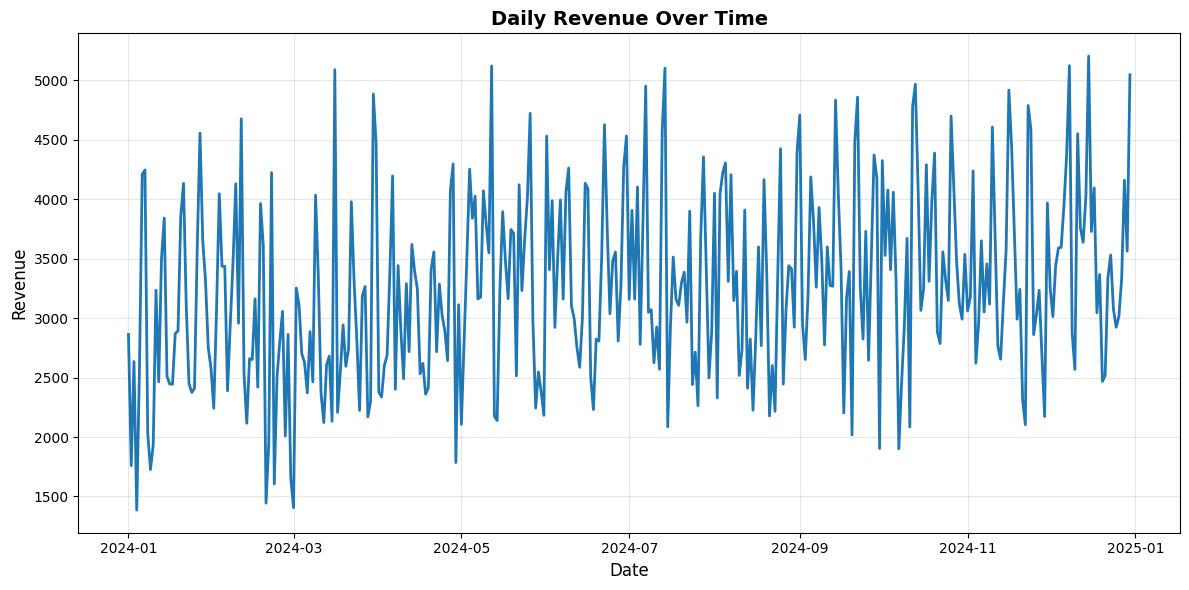

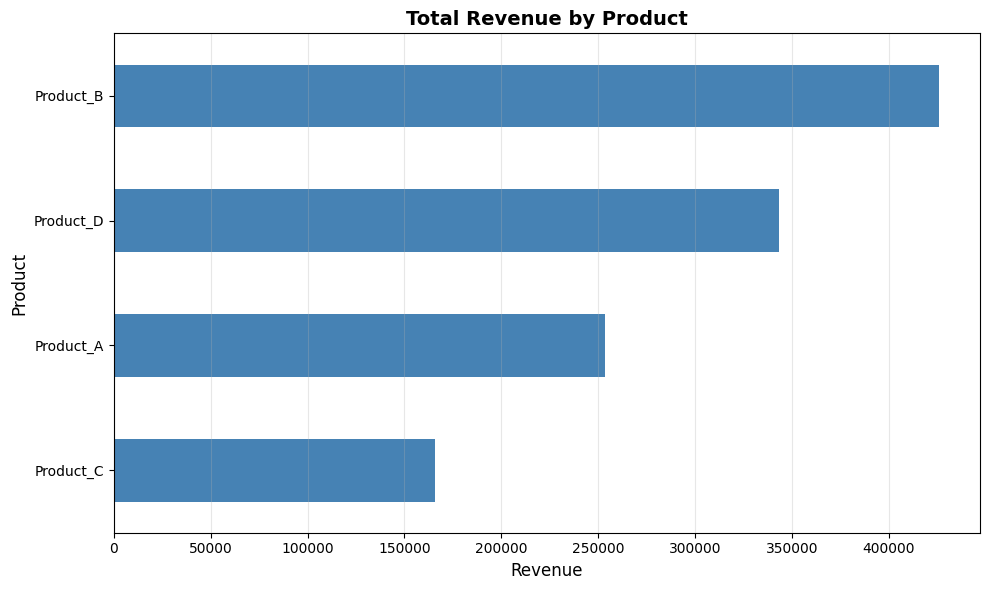

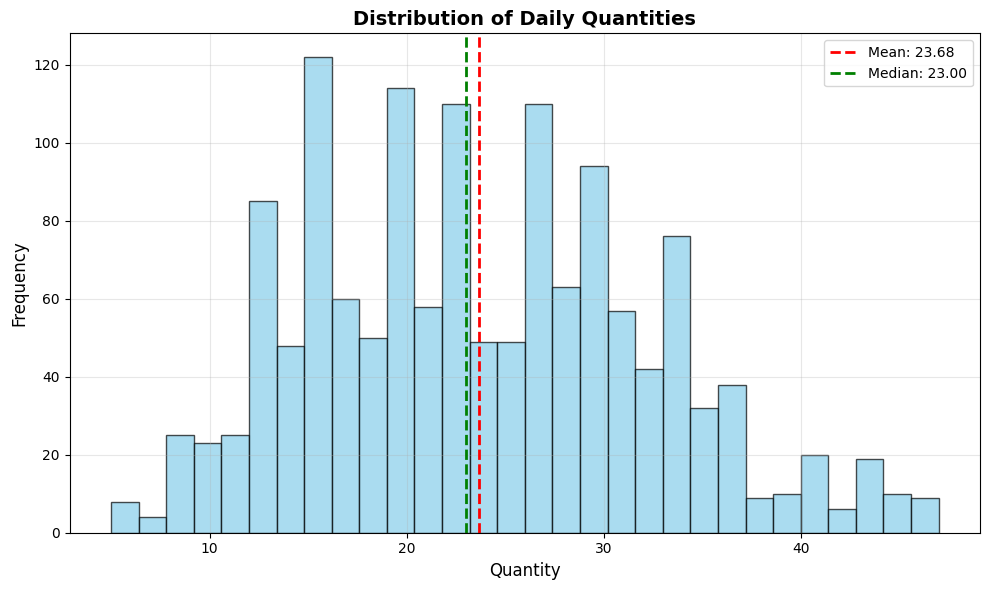

In [6]:
# This would be in: visualization.py

def plot_time_series(df, date_col='date', value_col='revenue', title='Sales Over Time'):
    """
    Plot time series data.
    
    Parameters
    ----------
    df : pd.DataFrame
        Data to plot
    date_col : str
        Date column name
    value_col : str
        Value column name
    title : str
        Plot title
    """
    daily_sales = df.groupby(date_col)[value_col].sum().reset_index()
    
    plt.figure(figsize=(12, 6))
    plt.plot(daily_sales[date_col], daily_sales[value_col], linewidth=2)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel(value_col.capitalize(), fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_product_comparison(df, metric='revenue'):
    """
    Plot comparison between products.
    
    Parameters
    ----------
    df : pd.DataFrame
        Sales DataFrame
    metric : str
        Metric to compare: 'revenue' or 'quantity'
    """
    product_totals = df.groupby('product')[metric].sum().sort_values(ascending=True)
    
    plt.figure(figsize=(10, 6))
    product_totals.plot(kind='barh', color='steelblue')
    plt.title(f'Total {metric.capitalize()} by Product', fontsize=14, fontweight='bold')
    plt.xlabel(metric.capitalize(), fontsize=12)
    plt.ylabel('Product', fontsize=12)
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_distribution(df, column, bins=30, title=None):
    """
    Plot distribution of a numerical column.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame
    column : str
        Column to plot
    bins : int
        Number of histogram bins
    title : str, optional
        Plot title
    """
    plt.figure(figsize=(10, 6))
    
    # Histogram
    plt.hist(df[column].dropna(), bins=bins, alpha=0.7, color='skyblue', edgecolor='black')
    
    # Add mean and median lines
    mean_val = df[column].mean()
    median_val = df[column].median()
    plt.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
    plt.axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Median: {median_val:.2f}')
    
    plt.title(title or f'Distribution of {column}', fontsize=14, fontweight='bold')
    plt.xlabel(column.capitalize(), fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Create visualizations
print("Creating Visualizations...\n")

# Time series
plot_time_series(df_clean, value_col='revenue', title='Daily Revenue Over Time')

# Product comparison
plot_product_comparison(df_clean, metric='revenue')

# Distribution
plot_distribution(df_clean, 'quantity', bins=30, title='Distribution of Daily Quantities')

## Part 3: Complete Analysis Pipeline

### Bringing It All Together

In [7]:
def complete_sales_analysis(df, output_report=True):
    """
    Complete end-to-end sales analysis pipeline.
    
    Parameters
    ----------
    df : pd.DataFrame
        Raw sales data
    output_report : bool
        Whether to print detailed report
    
    Returns
    -------
    dict
        Dictionary containing all analysis results
    """
    results = {}
    
    if output_report:
        print("\n" + "=" * 60)
        print("COMPLETE SALES ANALYSIS REPORT")
        print("=" * 60)
    
    # Step 1: Data Quality
    if output_report:
        print("\n[1] DATA QUALITY ASSESSMENT")
        print("-" * 60)
    
    quality_report = data_quality_report(df)
    results['quality'] = quality_report
    
    if output_report:
        print(f"Total Rows: {quality_report['total_rows']:,}")
        print(f"Total Columns: {quality_report['total_columns']}")
        print(f"Duplicates: {quality_report['duplicates']}")
        print(f"Memory Usage: {quality_report['memory_usage']:.2f} MB")
        
        for col, info in quality_report['outliers'].items():
            if info['count'] > 0:
                print(f"\nOutliers in {col}: {info['count']} ({info['percentage']:.2f}%)")
    
    # Step 2: Preprocessing
    if output_report:
        print("\n[2] DATA PREPROCESSING")
        print("-" * 60)
    
    df_processed = handle_missing_values(df, strategy='median')
    original_size = len(df_processed)
    df_processed = remove_outliers(df_processed, 'quantity')
    df_processed = add_date_features(df_processed)
    
    results['processed_data'] = df_processed
    
    if output_report:
        print(f"Rows after preprocessing: {len(df_processed):,}")
        print(f"Rows removed: {original_size - len(df_processed)} ({((original_size - len(df_processed))/original_size)*100:.2f}%)")
    
    # Step 3: Descriptive Statistics
    if output_report:
        print("\n[3] DESCRIPTIVE STATISTICS")
        print("-" * 60)
    
    stats = {
        'total_revenue': df_processed['revenue'].sum(),
        'avg_daily_revenue': df_processed.groupby('date')['revenue'].sum().mean(),
        'total_quantity': df_processed['quantity'].sum(),
        'avg_daily_quantity': df_processed.groupby('date')['quantity'].sum().mean(),
        'unique_products': df_processed['product'].nunique(),
        'date_range_days': (df_processed['date'].max() - df_processed['date'].min()).days
    }
    results['statistics'] = stats
    
    if output_report:
        print(f"Total Revenue: ${stats['total_revenue']:,.2f}")
        print(f"Avg Daily Revenue: ${stats['avg_daily_revenue']:,.2f}")
        print(f"Total Quantity Sold: {stats['total_quantity']:,.0f}")
        print(f"Avg Daily Quantity: {stats['avg_daily_quantity']:,.0f}")
        print(f"Products: {stats['unique_products']}")
        print(f"Date Range: {stats['date_range_days']} days")
    
    # Step 4: Product Analysis
    if output_report:
        print("\n[4] PRODUCT PERFORMANCE")
        print("-" * 60)
    
    product_perf = product_performance(df_processed)
    results['product_performance'] = product_perf
    
    if output_report:
        print(product_perf)
    
    # Step 5: Time-based Analysis
    if output_report:
        print("\n[5] TEMPORAL ANALYSIS")
        print("-" * 60)
    
    monthly_sales = sales_by_period(df_processed, period='month')
    weekend_analysis = weekend_vs_weekday_analysis(df_processed)
    
    results['monthly_sales'] = monthly_sales
    results['weekend_analysis'] = weekend_analysis
    
    if output_report:
        print("\nWeekend vs Weekday Sales:")
        print(weekend_analysis)
        
        weekend_revenue = weekend_analysis.loc['Weekend', ('revenue', 'sum')]
        weekday_revenue = weekend_analysis.loc['Weekday', ('revenue', 'sum')]
        weekend_boost = ((weekend_revenue - weekday_revenue) / weekday_revenue) * 100
        print(f"\nWeekend Revenue Boost: {weekend_boost:.2f}%")
    
    # Step 6: Growth Analysis
    if output_report:
        print("\n[6] GROWTH ANALYSIS")
        print("-" * 60)
    
    growth = calculate_growth_rate(df_processed, period='month')
    results['growth'] = growth
    
    if output_report:
        avg_growth = growth['growth_rate'].mean()
        print(f"Average Monthly Growth Rate: {avg_growth:.2f}%")
        print("\nMonthly Growth Rates:")
        for _, row in growth.iterrows():
            if not pd.isna(row['growth_rate']):
                print(f"  Month {int(row['month'])}: {row['growth_rate']:+.2f}%")
    
    if output_report:
        print("\n" + "=" * 60)
        print("ANALYSIS COMPLETE")
        print("=" * 60)
    
    return results

# Run complete analysis
results = complete_sales_analysis(df, output_report=True)


COMPLETE SALES ANALYSIS REPORT

[1] DATA QUALITY ASSESSMENT
------------------------------------------------------------
Total Rows: 1,460
Total Columns: 5
Duplicates: 0
Memory Usage: 0.13 MB

Outliers in quantity: 6 (0.42%)

Outliers in revenue: 20 (1.37%)

[2] DATA PREPROCESSING
------------------------------------------------------------
Rows after preprocessing: 1,425
Rows removed: 35 (2.40%)

[3] DESCRIPTIVE STATISTICS
------------------------------------------------------------
Total Revenue: $1,188,039.30
Avg Daily Revenue: $3,254.90
Total Quantity Sold: 33,748
Avg Daily Quantity: 92
Products: 4
Date Range: 364 days

[4] PRODUCT PERFORMANCE
------------------------------------------------------------
           quantity_sum  quantity_mean  quantity_std  revenue_sum  \
product                                                             
Product_B        8497.0          23.87          8.63    425781.16   
Product_D        8582.0          23.77          8.54    343205.52   
Produc

C:\Users\avidaldo\AppData\Local\Temp\ipykernel_8384\1975110755.py:31: ChainedAssignmentError: A value is being set on a copy of a DataFrame or Series through chained assignment using an inplace method.
Such inplace method never works to update the original DataFrame or Series, because the intermediate object on which we are setting values always behaves as a copy (due to Copy-on-Write).

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' instead, to perform the operation inplace on the original object, or try to avoid an inplace operation using 'df[col] = df[col].method(value)'.

See the documentation for a more detailed explanation: https://pandas.pydata.org/pandas-docs/stable/user_guide/copy_on_write.html
  df_copy[col].fillna(df_copy[col].median(), inplace=True)


## Part 4: How to Organize as a Package

### Recommended Package Structure

If we were to organize all the above code into a proper package:

```
sales_analytics/
├── README.md
├── requirements.txt
├── setup.py
├── sales_analytics/
│   ├── __init__.py
│   ├── quality/
│   │   ├── __init__.py
│   │   └── checks.py          # Data quality functions
│   ├── preprocessing/
│   │   ├── __init__.py
│   │   ├── cleaning.py        # Missing values, outliers
│   │   └── features.py        # Feature engineering
│   ├── analysis/
│   │   ├── __init__.py
│   │   ├── descriptive.py     # Descriptive statistics
│   │   ├── temporal.py        # Time-based analysis
│   │   └── products.py        # Product analysis
│   ├── visualization/
│   │   ├── __init__.py
│   │   ├── plots.py           # Plotting functions
│   │   └── dashboards.py      # Dashboard creation
│   └── pipeline.py            # Complete pipeline
├── tests/
│   ├── __init__.py
│   ├── test_quality.py
│   ├── test_preprocessing.py
│   └── test_analysis.py
└── examples/
    ├── basic_usage.py
    └── advanced_analysis.py
```

### Example `__init__.py` Files

**`sales_analytics/__init__.py`**
```python
"""
Sales Analytics Package

A comprehensive package for sales data analysis including:
- Data quality assessment
- Preprocessing and cleaning
- Statistical analysis
- Visualization
"""

__version__ = '1.0.0'
__author__ = 'Data Analysis Team'

# Import key functions to package level
from .quality.checks import check_missing_values, detect_outliers_iqr
from .preprocessing.cleaning import handle_missing_values, remove_outliers
from .preprocessing.features import add_date_features
from .analysis.descriptive import sales_by_period, product_performance
from .visualization.plots import plot_time_series, plot_product_comparison
from .pipeline import complete_sales_analysis

__all__ = [
    'check_missing_values',
    'detect_outliers_iqr',
    'handle_missing_values',
    'remove_outliers',
    'add_date_features',
    'sales_by_period',
    'product_performance',
    'plot_time_series',
    'plot_product_comparison',
    'complete_sales_analysis'
]
```

**`sales_analytics/quality/__init__.py`**
```python
"""Data quality assessment module."""

from .checks import (
    check_missing_values,
    detect_outliers_iqr,
    data_quality_report
)

__all__ = [
    'check_missing_values',
    'detect_outliers_iqr',
    'data_quality_report'
]
```

### Usage Examples

Once organized as a package, users could use it like this:

```python
# Simple usage - import main functions
import sales_analytics as sa

# Load data
df = pd.read_csv('sales_data.csv')

# Quick analysis
results = sa.complete_sales_analysis(df)

# Or use specific functions
df_clean = sa.handle_missing_values(df)
df_clean = sa.remove_outliers(df_clean, 'quantity')
sa.plot_time_series(df_clean)
```

```python
# Advanced usage - import specific modules
from sales_analytics import preprocessing, analysis, visualization

# Preprocessing
df_clean = preprocessing.handle_missing_values(df)
df_clean = preprocessing.add_date_features(df_clean)

# Analysis
monthly = analysis.sales_by_period(df_clean, 'month')
products = analysis.product_performance(df_clean)

# Visualization
visualization.plot_time_series(df_clean)
visualization.plot_product_comparison(df_clean)
```

## Key Takeaways

✅ **Integration with Data Science Libraries:**
- Use standard aliases: `np`, `pd`, `plt`
- Leverage NumPy and Pandas for efficiency
- Build custom functions on top of these libraries

✅ **Modular Code Organization:**
- Separate concerns (quality, preprocessing, analysis, visualization)
- Each module has clear, single purpose
- Functions are reusable and testable

✅ **Complete Analysis Pipeline:**
- Data quality assessment
- Preprocessing and cleaning
- Statistical analysis
- Visualization
- Reproducible results

✅ **Package Structure:**
- Logical directory hierarchy
- Clear naming conventions
- Proper use of `__init__.py`
- Expose high-level API

✅ **Best Practices:**
- Comprehensive docstrings
- Type hints where appropriate
- Error handling
- Consistent coding style
- Documentation and examples

## Final Exercises

### Exercise 1: Extend the Analysis

Add a new analysis module with functions to:
1. Calculate customer lifetime value (if customer data available)
2. Perform cohort analysis
3. Identify best-selling product combinations
4. Forecast future sales using moving averages

### Exercise 2: Create Export Functionality

Add a new `export` module with functions to:
1. Export analysis results to CSV
2. Generate PDF reports with plots
3. Create Excel workbooks with multiple sheets
4. Export visualizations as PNG/SVG files

### Exercise 3: Build Your Own Package

Choose a domain (e.g., text analysis, image processing, financial analysis) and:
1. Design a complete package structure
2. Implement at least 3 submodules with 2-3 functions each
3. Create proper `__init__.py` files
4. Write comprehensive docstrings
5. Include a usage example
6. Test your package by importing and using it

### Exercise 4: Package Documentation

For the sales analytics package, create:
1. A comprehensive `README.md` with:
   - Installation instructions
   - Quick start guide
   - Usage examples
   - API reference
2. A `requirements.txt` file listing all dependencies
3. Example notebooks demonstrating key features
4. A `CHANGELOG.md` for version history

## Congratulations!

You've completed the comprehensive modules and packages series! You now understand:

✅ What modules and packages are and why they're important

✅ Different importing strategies and when to use each

✅ Python's standard library modules for data analysis

✅ How to create your own modules with proper structure

✅ How to organize code into packages with hierarchies

✅ How to integrate with NumPy, Pandas, and Matplotlib

✅ Best practices for documentation and code organization

✅ How to build complete, professional data analysis workflows

**Next Steps:**
- Practice by building your own packages
- Explore popular packages on PyPI to see how they're structured
- Learn about package distribution with `setuptools` and `pip`
- Study open-source projects to see real-world package design
- Consider contributing to existing packages to deepen your understanding